# Jupyter notebook solution for Chp. 3

This notebook contains a second solution to the problem that makes use of helper functions. It shows how helper functions can be defined then used to speed up the creation of scripts. It also gives a template using the Jupyter Notebook format. 

## Running the notebook
Make sure you have your virtual environment with diffpy activated. You will have to manually add a kernel for this virtual environment. You can install ipykernel which provides the IPython kernel for Jupyter:

You will now be able to select the new kernel and run the notebook. 

## Import the relevant packages

In [1]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import typing

from diffpy.utils.parsers.loaddata import loadData
from diffpy.srfit.fitbase import FitRecipe, FitContribution, Profile, FitResults
from diffpy.srfit.pdf import PDFGenerator, PDFParser
from diffpy.srfit.fitbase.parameterset import ParameterSet
from pyobjcryst import loadCrystal
from pyobjcryst.crystal import Crystal

#We import the form factors. We will use this to fit the Pt nanoparticles as spherical particles.
import diffpy.srfit.pdf.characteristicfunctions
F = diffpy.srfit.pdf.characteristicfunctions

## Define helper functions

"Songsheng's helper functions are used, in the tutorial it is mentioned that the helper functions would be published soon - How should these be cited/referenced currently?"\
"Where can the original code be found? We should write this"


Normally these helper functions will not need to be modified and you can use them as is, but to solve some of the specfic problems in the PDFttp book we will make small changes and additions to the recipe functions. The changes we have made will be highlighted in the code. 


### Create Recipe

Here a helper function is defined that creates a FitContribution and FitRecipe, taking the data and structure files as input. \
Because we want to refine the calibrant and determine instrumental parameters, qdamp and qbroad are added as parameters to our recipe under _add_params_in_pg.

In [2]:
def _create_recipe(
        equation: str,
        crystals: typing.Dict[str, Crystal],
        functions: typing.Dict[str, typing.Tuple[typing.Callable, typing.List[str]]],
        profile: Profile,
        fc_name: str = "PDF"
) -> FitRecipe:
    """Create the FitRecipe object.

    Parameters
    ----------
    equation :
        The equation of G(r).
    crystals :
        A mapping from the name of variable in the equation to the crystal structure for PDF calculation.
    functions :
        A mapping from the name of variable in the equation to the python function for PDF calculation.
        The first argument of the function is the array of r, the other arguments are the parameters.
    profile :
        The data profile that contains both the metadata and the data.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".

    Returns
    -------
    A FitRecipe object.
    """
    fr = FitRecipe()
    fc = FitContribution(fc_name)
    for name, crystal in crystals.items():
        pg = PDFGenerator(name)
        pg.setStructure(crystal, periodic=True)
        fc.addProfileGenerator(pg)
    for name, (f, argnames) in functions.items():
        fc.registerFunction(f, name=name, argnames=argnames)
    fc.setEquation(equation)
    fc.setProfile(profile, xname="r", yname="G", dyname="dG")
    fr.addContribution(fc)
    return fr


def _get_tags(phase: str, param: str) -> typing.List[str]:
    """Get the tag names.

    Parameters
    ----------
    phase
    param

    Returns
    -------

    """
    return [param, phase, "{}_{}".format(phase, param)]


def _get_name(*args: str) -> str:
    """Get the name of the variable.

    Parameters
    ----------
    args

    Returns
    -------

    """
    return "_".join(args)


def _rename_par(name: str, atoms: list) -> str:
    """Rename of the name of a parameter by replacing the index of the atom in the name by the label of
    the atom and revert the order of coordinates and atom name.

    Used for the space group constrained parameters. For example, "x_0" where atom index 0 is Ni will become
    "Ni0_x" after renamed. If the name can not renamed, return the original name.

    Parameters
    ----------
    name
    atoms

    Returns
    -------

    """
    parts = name.split("_")
    np = len(parts)
    na = len(atoms)
    if np > 1 and parts[1].isdigit() and -1 < int(parts[1]) < na:
        parts[1] = atoms[int(parts[1])].name
        parts = parts[::-1]
    return "_".join(parts)


def _add_params_in_pg(recipe: FitRecipe, pg: PDFGenerator) -> None:
    """Add parameters in the PDFGenerator.

    Parameters
    ----------
    recipe
    pg

    Returns
    -------

    """
    name: str = pg.name
    recipe.addVar(
        pg.scale,
        name=_get_name(name, "scale"),
        value=SCALE_I,
        fixed=True,
        tags=_get_tags(name, "scale")
    ).boundRange(0.)
    recipe.addVar(   #Here we add Qdamp as a variable
        pg.qdamp,
        name=_get_name(name, "qdamp"), 
        value=QDAMP_I, 
        fixed=True,
        tags=_get_tags(name, "qdamp")
    ).boundRange(0.)
    recipe.addVar(   #Here we add Qbroad as a variable
        pg.qbroad,
        name=_get_name(name, "qbroad"), 
        value=QBROAD_I, 
        fixed=True,
        tags=_get_tags(name, "qbroad")
    ).boundRange(0.)    
    recipe.addVar(
        pg.delta2,
        name=_get_name(name, "delta2"),
        value=DELTA2_I,
        fixed=True,
        tags=_get_tags(name, "delta2")
    ).boundRange(0.)
    latpars = pg.phase.sgpars.latpars
    for par in latpars:
        recipe.addVar(
            par,
            name=_get_name(name, par.name),
            fixed=True,
            tags=_get_tags(name, "lat")
        ).boundRange(0.)
    atoms: typing.List[ParameterSet] = pg.phase.getScatterers()
    for atom in atoms:
        par = atom.Biso
        recipe.addVar(
            par,
            name=_get_name(name, atom.name, "Biso"),
            value=BISO_I,
            fixed=True,
            tags=_get_tags(name, "adp")
        ).boundRange(0.)
    xyzpars = pg.phase.sgpars.xyzpars
    for par in xyzpars:
        par_name = _rename_par(par.name, atoms)
        recipe.addVar(
            par,
            name=_get_name(name, par_name),
            fixed=True,
            tags=_get_tags(name, "xyz")
        )
    return


def _add_params_in_fc(
        recipe: FitRecipe,
        fc: FitContribution,
        names: typing.List[str],
        tags: typing.List[str]
) -> None:
    """Add parameters in the FitContribution.

    Parameters
    ----------
    recipe
    fc
    names
    tags

    Returns
    -------

    """
    for name in names:
        par = getattr(fc, name)
        recipe.addVar(
            par,
            value=100.,
            fixed=True,
            tags=tags
        )
    return


def _initialize_recipe(
        recipe: FitRecipe,
        functions: typing.Dict[str, typing.Tuple[typing.Callable, typing.List[str]]],
        crystals: typing.Dict[str, Crystal],
        fc_name: str = "PDF"
) -> None:
    """Initialize the FitRecipe object with variables.

    The parameters are the scale of the PDF, the delta2 parameter in the correction of correlated motions,
    the atomic displacement parameters (ADPs) of the symmetric unique atoms, the x, y, z positions of the
    symmetric unique atoms under the constraint of the symmetry and the parameters in the functions registered
    in the FitContribution.

    Parameters
    ----------
    recipe
    functions
    crystals
    fc_name

    Returns
    -------

    """
    fc: FitContribution = getattr(recipe, fc_name)
    for name, (_, argnames) in functions.items():
        _add_params_in_fc(recipe, fc, argnames[1:], tags=[name])
    for name in crystals.keys():
        pg: PDFGenerator = getattr(fc, name)
        _add_params_in_pg(recipe, pg)
    recipe.clearFitHooks()
    return


def create_recipe_from_files(
        equation: str,
        cif_files: typing.Dict[str, str],
        functions: typing.Dict[str, typing.Tuple[typing.Callable, typing.List[str]]],
        data_file: typing.Dict[str, str],
        meta_data: typing.Dict[str, typing.Union[str, int, float]] = None,
        fc_name: str = "PDF"
) -> FitRecipe:
    """Create the FitRecipe object.

    Parameters
    ----------
    equation :
        The equation of G(r).
    cif_files :
        A mapping from the name of variable in the equation to cif files of the crystal structure for PDF
        calculation.
    functions :
        A mapping from the name of variable in the equation to the python function for PDF calculation.
        The first argument of the function is the array of r, the other arguments are the parameters.
    data_file :
        The data file that be loaded into the data profile that contains both the metadata and the data.
    meta_data :
        Additional metadata to add into the data profile.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".

    Returns
    -------
    A FitRecipe object.
    """
    if meta_data is None:
        meta_data = {}
    crystals = {n: loadCrystal(f) for n, f in cif_files.items()}
    pp = PDFParser()
    pp.parseFile(data_file)
    profile = Profile()
    profile.loadParsedData(pp)
    profile.meta.update(meta_data)
    recipe = _create_recipe(equation, crystals, functions, profile, fc_name=fc_name)
    _initialize_recipe(recipe, functions, crystals, fc_name=fc_name)
    return recipe

### Define Optimize function

Here, the parameters in the FitRecipe are optimized with a least square regression. This helper function is not modified and you do not need to go through it.

In [35]:
def optimize_params(
        recipe: FitRecipe,
        steps: typing.List[typing.List[str]],
        rmin: float = None,
        rmax: float = None,
        rstep: float = None,
        print_step: bool = True,
        fc_name: str = "PDF",
        **kwargs
) -> None:
    """Optimize the parameters in the FitRecipe object using least square regression.

    Parameters
    ----------
    recipe :
        The FitRecipe object.
    steps :
        A list of lists of parameter names in the recipe. They will be free and refined one batch after another.
        Usually, the scale, lattice should be refined before the APD and XYZ.
    rmin :
        The minimum r in the range for refinement. If None, use the minimum r in the data.
    rmax :
        The maximum r in the range for refinement. If None, use the maximum r in the data.
    rstep :
        The step of r in the range for refinement. If None, use the step of r in the data.
    print_step :
        If True, print out the refinement step. Default True.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".
    kwargs :
        The kwargs for the `scipy.optimize.least_square`.

    Returns
    -------
    None.
    """
    n = len(steps)
    fc: FitContribution = getattr(recipe, fc_name)
    p: Profile = fc.profile
    p.setCalculationRange(xmin=rmin, xmax=rmax, dx=rstep)
    for step in steps:
        recipe.fix(*step)
    for i, step in enumerate(steps):
        recipe.free(*step)
        if print_step:
            print(
                "Step {} / {}: refine {}".format(
                    i + 1, n, ", ".join(recipe.getNames())
                ),
                end="\r"
            )
        least_squares(recipe.residual, recipe.getValues(), bounds=recipe.getBounds2(), **kwargs)
    return


### Define visualize fits
This helper function is not modified and you do not need to go through it.

In [36]:
def visualize_fits(recipe: FitRecipe, xlim: typing.Tuple = None, fc_name: str = "PDF") -> None:
    """Visualize the fits in the FitRecipe object.

    Parameters
    ----------
    recipe :
        The FitRecipe object.
    xlim :
        The boundary of the x to show in the plot.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".

    Returns
    -------
    None.
    """
    # get data
    fc = getattr(recipe, fc_name)
    r = fc.profile.x
    g = fc.profile.y
    gcalc = fc.profile.ycalc
    if xlim is not None:
        sel = np.logical_and(r >= xlim[0], r <= xlim[1])
        r = r[sel]
        g = g[sel]
        gcalc = gcalc[sel]
    gdiff = g - gcalc
    diffzero = -0.8 * np.max(g) * np.ones_like(g)
    # plot figure
    _, ax = plt.subplots()
    ax.plot(r, g, 'bo', label="G(r) Data")
    ax.plot(r, gcalc, 'r-', label="G(r) Fit")
    ax.plot(r, gdiff + diffzero, 'g-', label="G(r) Diff")
    ax.plot(r, diffzero, 'k-')
    ax.set_xlabel(r"$r (\AA)$")
    ax.set_ylabel(r"$G (\AA^{-2})$")
    ax.legend(loc=1)
    plt.show()
    return

### Save results in files
This helper function is not modified and you do not need to go through it.

In [37]:
def save_results(
        recipe: FitRecipe,
        directory: str,
        file_stem: str,
        pg_names: typing.List[str] = None,
        fc_name: str = "PDF"
) -> None:
    """Save the parameters, fits and structures in the FitRecipe object.

    Parameters
    ----------
    recipe :
        The FitRecipe object.
    directory :
        The directory to output the files.
    file_stem :
        The stem of the filename.
    pg_names :
        The name of the PDFGenerators (it will also be the name of the structures) to save. If None, not to save.
    fc_name
        The name of the FitContribution in the FitRecipe. Default "PDF".
    Returns
    -------
    None.
    """
    d_path = Path(directory)
    d_path.mkdir(parents=True, exist_ok=True)
    f_path = d_path.joinpath(file_stem)
    fr = FitResults(recipe)
    fr.saveResults(str(f_path.with_suffix(".res")))
    fc: FitContribution = getattr(recipe, fc_name)
    profile: Profile = fc.profile
    profile.savetxt(str(f_path.with_suffix(".fgr")))
    if pg_names is not None:
        for pg_name in pg_names:
            pg: PDFGenerator = getattr(fc, pg_name)
            stru: Crystal = pg.stru
            cif_path = f_path.with_name(
                "{}_{}".format(f_path.stem, pg_name)
            ).with_suffix(".cif")
            with cif_path.open("w") as f:
                stru.CIFOutput(f)
    return

## Determine Q$_{damp}$ and Q$_{broad}$ from Ni standard
### Fit Ni Short range

In [38]:
#We specify the data path. 
DPATH = '../../../data/'

GR_FILE = DPATH + 'Ni.gr'
CIF_FILE = DPATH + 'Ni.cif'

In [39]:
#PDF initial values
SCALE_I = 0.4
BISO_I = 0.02
DELTA2_I = 2
QDAMP_I = 0.04
QBROAD_I = 0.02

In [40]:
recipe = create_recipe_from_files(
    "Ni",
    cif_files={"Ni": CIF_FILE},
    functions={},
    data_file=GR_FILE,
)

In [41]:
recipe.show()

Parameters
------------------------------------------------------------------------------
Ni_scale        0.4
Ni_qdamp        0.04
Ni_qbroad       0.02
Ni_delta2       2.0
Ni_a            3.52
Ni_Ni1_Biso     0.02

PDF.r   [0.000e+00 1.000e-02 2.000e-02 ... 5.998e+01 5.999e+01 6.000e+01]
PDF.G   [ 0.         -0.00049796 -0.00096337 ...  0.0325963   0.0272721
  0.02
PDF.dG  [1. 1. 1. ... 1. 1. 1.]

PDF.Ni.delta1   0.0
PDF.Ni.delta2   2.0
PDF.Ni.qbroad   0.02
PDF.Ni.scale    0.4
PDF.Ni.qdamp    0.04

PDF.Ni.phase.a      3.52
PDF.Ni.phase.b      3.52
PDF.Ni.phase.c      3.52
PDF.Ni.phase.alpha  1.5707963267948966
PDF.Ni.phase.beta   1.5707963267948966
PDF.Ni.phase.gamma  1.5707963267948966

PDF.Ni.phase.Ni1.x      0.0
PDF.Ni.phase.Ni1.y      0.0
PDF.Ni.phase.Ni1.z      0.0
PDF.Ni.phase.Ni1.occ    1.0
PDF.Ni.phase.Ni1.Biso   0.02
PDF.Ni.phase.Ni1.B11    0.0
PDF.Ni.phase.Ni1.B22    0.0
PDF.Ni.phase.Ni1.B33    0.0
PDF.Ni.phase.Ni1.B12    0.0
PDF.Ni.phase.Ni1.B21    0.0
PDF.Ni.phase.Ni1.B13  

In [42]:
# We optimize the recipe, here done in two steps. First the scale and lattice parameters, next the ADPs, Qdamp, and delta2.
optimize_params(
    recipe,
    [
        ["Ni_scale", "Ni_lat"], 
        ["Ni_adp", 'Ni_qdamp',"Ni_delta2"]
    ],
    rmin=1.6,
    rmax=20.0,
    ftol=1e-4
)

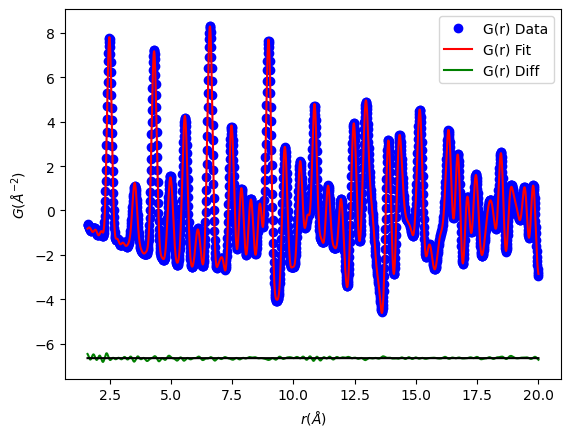

In [43]:
visualize_fits(recipe)

In [44]:
#The results from our refined recipe are saved with the save_results function. 
save_results(recipe, "Results/Ni", "Ni_short_r", ["Ni"])

In [45]:
# We open the .res file we just generated
!cat "./Results/Ni/Ni_short_r.res"

Results written: Mon Nov 21 10:22:26 2022
produced by sarafrank

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       4.28854291
Contributions  4.28854291
Restraints     0.00000000
Chi2           4.28854291
Reduced Chi2   0.00233581
Rw             0.02123078

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Ni_Ni1_Biso  4.51892665e-01 +/- 1.02553391e-02
Ni_a         3.52476911e+00 +/- 3.50742567e-04
Ni_delta2    1.70715027e+00 +/- 3.36711521e-01
Ni_qdamp     4.79896978e-02 +/- 2.68644356e-03
Ni_scale     4.41853429e-01 +/- 8.42563724e-03

Fixed Variables
------------------------------------------------------------------------------
Ni_qbroad  2.00000000e-02

Variable Correlations greater than 25% (Correlations invalid)
-------------------------------------------------------------------

### Fit Ni full range

In [46]:
recipe = create_recipe_from_files(
    "Ni",
    cif_files={"Ni": CIF_FILE},
    functions={},
    data_file=GR_FILE
)

In [47]:
#We will use initializeRecipe to load the refined parameter values from the short range fit
from diffpy.srfit.fitbase.fitresults import initializeRecipe

initializeRecipe(recipe, "./Results/Ni/Ni_short_r.res")

In [48]:
optimize_params(
    recipe,
    [
        ["Ni_scale", "Ni_lat"], 
        ["Ni_adp", 'Ni_qdamp',"Ni_delta2"],
        ['Ni_qbroad']
    ],
    rmin=1.6,
    rmax=50.0,
    ftol=1e-4
)

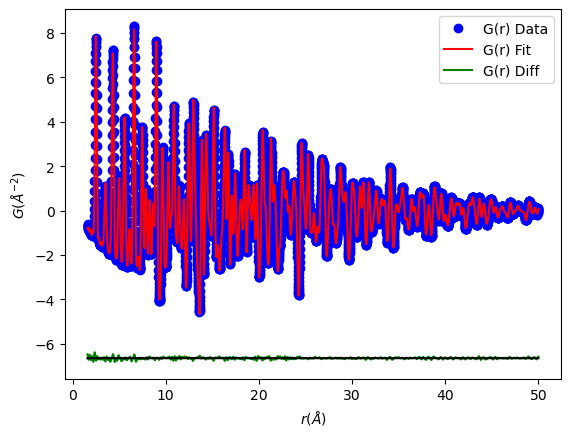

In [49]:
visualize_fits(recipe)

In [50]:
save_results(recipe, "Results/Ni", "Ni_full_r", ["Ni"])

In [51]:
# We want to save the refined values from the standard fit of Ni and use it in our Pt fit
for index,name in enumerate(recipe.names):
    if 'qdamp' in name:
        QDAMP_Ni = recipe.values[index]
    if 'qbroad' in name:
        QBROAD_Ni = recipe.values[index]
print(QDAMP_Ni,QBROAD_Ni)

0.04530056994019807 0.016806354986184213


## Pt NPs

In [52]:
GR_FILE_Pt = DPATH + 'Pt-nanoparticles.gr'
CIF_FILE_Pt = DPATH + 'Pt.cif'

In [53]:
recipe = create_recipe_from_files(
    "sphere * Pt",
    cif_files={"Pt": CIF_FILE_Pt},
    functions={"sphere": (F.sphericalCF, ["r", "Pt_size"])},
    data_file=GR_FILE_Pt,
)

#We set the values of QDAMP and QBROAD to Ni
recipe.Pt_qdamp.setValue(QDAMP_Ni)
recipe.Pt_qbroad.setValue(QBROAD_Ni)

In [54]:
recipe.show()

Parameters
------------------------------------------------------------------------------
Pt_size         100.0
Pt_scale        0.4
Pt_qdamp        0.04530056994019807
Pt_qbroad       0.016806354986184213
Pt_delta2       2.0
Pt_a            3.9237
Pt_Pt1_Biso     0.02

PDF.r           [0.000e+00 1.000e-02 2.000e-02 ... 5.998e+01 5.999e+01 6.000e+
PDF.Pt_size     100.0
PDF.G           [ 0.         -0.00050444 -0.00097593 ...  0.0107819   0.009698
PDF.dG          [1. 1. 1. ... 1. 1. 1.]

PDF.Pt.delta1   0.0
PDF.Pt.delta2   2.0
PDF.Pt.qbroad   0.016806354986184213
PDF.Pt.scale    0.4
PDF.Pt.qdamp    0.04530056994019807

PDF.Pt.phase.a      3.9237
PDF.Pt.phase.b      3.9237
PDF.Pt.phase.c      3.9237
PDF.Pt.phase.alpha  1.5707963267948966
PDF.Pt.phase.beta   1.5707963267948966
PDF.Pt.phase.gamma  1.5707963267948966

PDF.Pt.phase.Pt1.x      0.0
PDF.Pt.phase.Pt1.y      0.0
PDF.Pt.phase.Pt1.z      0.0
PDF.Pt.phase.Pt1.occ    1.0
PDF.Pt.phase.Pt1.Biso   0.02
PDF.Pt.phase.Pt1.B11    0.0
PDF.Pt.

In [55]:
optimize_params(
    recipe,
    [
        ["Pt_scale", "Pt_lat"], 
        ["Pt_adp", "Pt_delta2"], 
        ["Pt_size"]
    ],
    rmin=1.6,
    rmax=20.0,
    ftol=1e-4
)

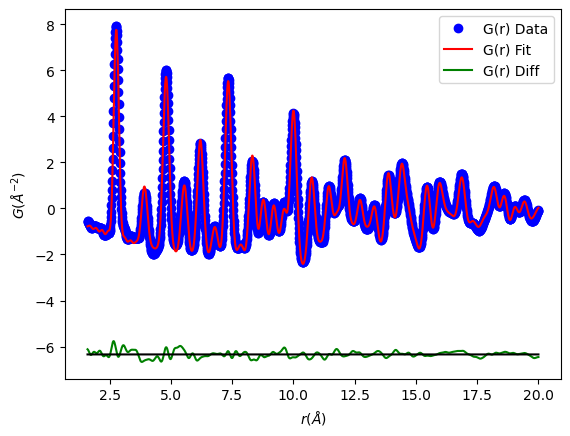

In [56]:
visualize_fits(recipe)

In [57]:
save_results(recipe, "Results/Pt", "Pt_short_r", ["Pt"])

In [58]:
!cat "./Results/Pt/Pt_short_r.res"

Results written: Mon Nov 21 10:22:31 2022
produced by sarafrank

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       35.81348848
Contributions  35.81348848
Restraints     0.00000000
Chi2           35.81348848
Reduced Chi2   0.01950626
Rw             0.09183806

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Pt_Pt1_Biso  6.84922370e-01 +/- 2.70473407e-02
Pt_a         3.92478149e+00 +/- 9.67560535e-04
Pt_delta2    3.25559156e+00 +/- 3.58739721e-01
Pt_scale     6.06854439e-01 +/- 1.78611229e-02
Pt_size      3.40338956e+01 +/- 1.50217871e+00

Fixed Variables
------------------------------------------------------------------------------
Pt_qbroad  1.68063550e-02
Pt_qdamp   4.53005699e-02

Variable Correlations greater than 25% (Correlations invalid)
--------------------------------------

### Pt Full range fit

In [59]:
recipe = create_recipe_from_files(
    "sphere * Pt",
    cif_files={"Pt": CIF_FILE_Pt},
    functions={"sphere": (F.sphericalCF, ["r", "Pt_size"])},
    data_file=GR_FILE_Pt
)


initializeRecipe(recipe, "./Res/Pt/Pt_short_r.res")

optimize_params(
    recipe,
    [
        ["Pt_scale", "Pt_lat"], 
        ["Pt_adp", "Pt_delta2"], 
        ["Pt_size"]
    ],
    rmin=1.6,
    rmax=50, #We increase rmax to 50 to fit over the full r-range
    ftol=1e-4
)

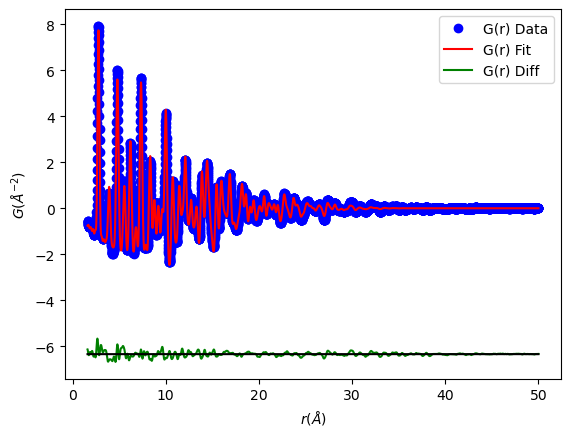

In [60]:
visualize_fits(recipe)

In [61]:
save_results(recipe, "Results/Pt", "Pt_full_r", ["Pt"])

In [62]:
!cat "./Results/Pt/Pt_full_r.res"

Results written: Mon Nov 21 10:22:34 2022
produced by sarafrank

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       48.20945213
Contributions  48.20945213
Restraints     0.00000000
Chi2           48.20945213
Reduced Chi2   0.00996887
Rw             0.10572728

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Pt_Pt1_Biso  7.05401842e-01 +/- 2.63579357e-02
Pt_a         3.92485517e+00 +/- 9.12911895e-04
Pt_delta2    3.54822112e+00 +/- 3.23574176e-01
Pt_scale     5.86057490e-01 +/- 1.58347522e-02
Pt_size      3.74145404e+01 +/- 1.35444023e+00

Fixed Variables
------------------------------------------------------------------------------
Pt_qbroad  1.68063550e-02
Pt_qdamp   4.53005699e-02

Variable Correlations greater than 25% (Correlations invalid)
--------------------------------------